# Isiah Montalvo Evil Geniuses Data Analyst Internship Assessment
To the wonderful person who ends up reviewing this assessment over at Evil Geniuses, I hope this finds you well! Throughout this notebook, I will be answering your required questions and detailing both my analysis and my thought process behind how I choose to explore this dataset. 

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

In [2]:
df = pd.read_excel("data/social_data.xlsx")

## Data Cleaning
First things first, data cleaning! Python packages tend to dislike whitespace, so we simply remove all leading and trailing whitespace from the data and replace spaces between words with an underscore.

In [3]:
df.dtypes

Published Date       datetime64[ns]
Account                      object
Account Type                 object
Campaign Name                object
Total Impressions             int64
Total Engagements             int64
Media Type                   object
dtype: object

In [4]:
df.columns = [column.replace(" ", "_") for column in df.columns]

In [5]:
columns = ["Account", "Account_Type", "Campaign_Name", "Media_Type"]
for column in columns:
    df[column] = df[column].str.strip().str.replace(" ", "_")
    print("Unique {} values: {}".format(column, df[column].unique()))

Unique Account values: ['CSGO' 'General' 'DOTA2' 'Content_Creators' 'Valorant']
Unique Account_Type values: ['TWITTER' 'FBPAGE' 'INSTAGRAM' 'TIKTOK_BUSINESS' 'YOUTUBE'
 'LINKEDIN_COMPANY']
Unique Campaign_Name values: ['N/A' 'Community_Engagement' 'Evergreen' 'Evil_Exhibited']
Unique Media_Type values: ['Text' 'Video' 'Photo' 'Link' 'Carousel' 'Mixed' 'Album']


In [6]:
df.head()

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community_Engagement,9517,1215,Video


# Tasks: 

## 1) What is the typical engagement rate we can expect? What's the likelihood that we can achieve a 15% engagement rate?
Considering the dataset possesses both engagements and impressions, the engagement rate by impressions will be calculated with the following formula: $$ Engagement Rate  = (\frac{engagements}{impressions}) * 100$$
Typical engagement rate will be interpreted as the average engagement rate of the dataset and will be calculated with the formula: $$ Typical Engagement Rate = (\frac{\sum{engagementRates}}{totalPosts}) * 100$$

In [7]:
def engagementRate(engagements, impressions):
    return (engagements / impressions) * 100

def averageEngagementRate(engagementRates):
    return np.mean(engagementRates)

Looking at the engagement rate formula, we know that the impressions can never be 0 or we risk dividing by 0. We solve this problem by removing all posts with 0 impressions from the dataset.

In [8]:
badIndexes = df.query("Total_Impressions == 0").index
df = df.drop(badIndexes).reset_index(drop=True)
df.query("Total_Impressions == 0").size

0

In [9]:
engagementRates = engagementRate(df.Total_Engagements, df.Total_Impressions)
typicalEngagementRate = averageEngagementRate(engagementRates)
print("The typical engagement rate we can expect is {0:.2f}%".format(typicalEngagementRate))

The typical engagement rate we can expect is 40.49%


The average engagement rate here is abnormally high especially since normal engagement rates tend to fall between 1% and 3%. Since numbers this big tend to be caused by large outliers, we begin by checking if any engagement rate is larger than 100%. All engagement rates should be less than or equal to 100% considering it's a ratio. 

In [10]:
if any(er > 100 for er in engagementRates):
    print("Investigate")
else:
    print("All good")

Investigate


In [11]:
df.query("Total_Engagements > Total_Impressions")

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type
642,2023-03-10 12:37:06,General,FBPAGE,N/A,1,940,Photo
2545,2023-01-19 06:02:34,General,FBPAGE,N/A,5,44,Photo
2725,2023-01-05 11:55:44,General,FBPAGE,N/A,300,3776,Photo


It seems we found the culprit! There are a few post where the total engagements for the post is larger than the total impressions of the post which is impossible. We consider this an error in data collection, delete these posts from the dataset, and recalculate the typical engagement rate.

In [12]:
badIndexes = df.query("Total_Engagements > Total_Impressions").index
df = df.drop(badIndexes).reset_index(drop=True)
df.query("Total_Engagements > Total_Impressions").size

0

In [13]:
engagementRates = engagementRate(df.Total_Engagements, df.Total_Impressions)
typicalEngagementRate = averageEngagementRate(engagementRates)
print("The typical engagement rate we can expect is {0:.2f}%".format(typicalEngagementRate))

The typical engagement rate we can expect is 5.35%


This number makes a lot more sense and has the added bonus of showcasing great engagement from posts on average. 

In [14]:
df["Engagement_Rates"] = engagementRates
df.head()

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type,Engagement_Rates
0,2023-03-31 19:43:42.590,CSGO,TWITTER,Community_Engagement,9517,1215,Video,12.766628
1,2023-03-31 19:40:57.383,CSGO,TWITTER,Community_Engagement,1882,83,Photo,4.410202
2,2023-03-31 19:23:57.349,CSGO,TWITTER,Community_Engagement,17892,3076,Video,17.192041
3,2023-03-31 18:55:51.855,CSGO,TWITTER,Community_Engagement,13874,1447,Video,10.429581
4,2023-03-31 18:36:01.000,General,FBPAGE,Community_Engagement,37692,8044,Photo,21.341399


To calculate the likelihood of achieving a 15% engagement rate, we can use a probability distributution to determine the probability of achieving such an engagement rate. The problem is, which one to use? We start our investigation by plotting a histogram of the engagement rate values. 

Text(0, 0.5, 'Frequency')

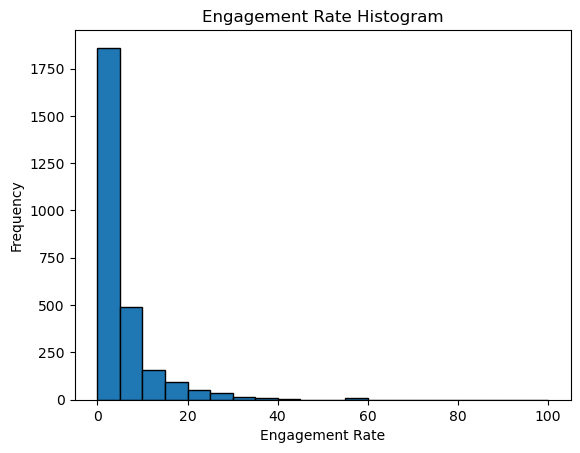

In [15]:
plt.hist(df.Engagement_Rates, edgecolor = "black", bins = 20)
plt.title("Engagement Rate Histogram")
plt.xlabel("Engagement Rate")
plt.ylabel("Frequency")

The engagement rate data seems to follow a right-skewed distribution. The initial impression is that this follows a lognormal distribution. We can test this by transforming the engagement rates using the natural logarithm and plotting the histogram again to see if it follows a normal distribution. 

In [16]:
badIndexes = df.query("Engagement_Rates == 0").index
probDF = df.drop(badIndexes).reset_index(drop=True)
probDF.head()

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type,Engagement_Rates
0,2023-03-31 19:43:42.590,CSGO,TWITTER,Community_Engagement,9517,1215,Video,12.766628
1,2023-03-31 19:40:57.383,CSGO,TWITTER,Community_Engagement,1882,83,Photo,4.410202
2,2023-03-31 19:23:57.349,CSGO,TWITTER,Community_Engagement,17892,3076,Video,17.192041
3,2023-03-31 18:55:51.855,CSGO,TWITTER,Community_Engagement,13874,1447,Video,10.429581
4,2023-03-31 18:36:01.000,General,FBPAGE,Community_Engagement,37692,8044,Photo,21.341399


Text(0, 0.5, 'Frequency')

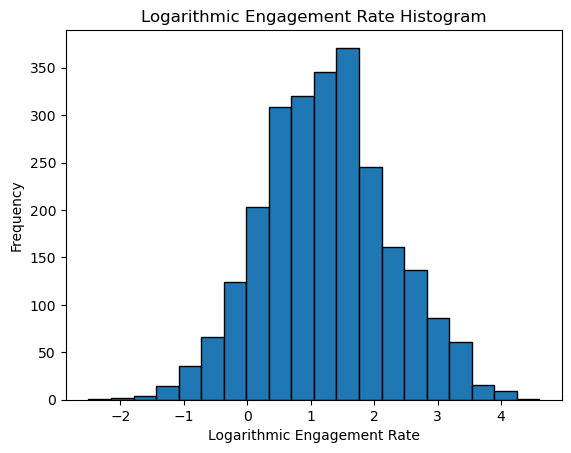

In [17]:
logERS = np.log(probDF.Engagement_Rates)
plt.hist(logERS, edgecolor = "black", bins = 20)
plt.title("Logarithmic Engagement Rate Histogram")
plt.xlabel("Logarithmic Engagement Rate")
plt.ylabel("Frequency")

Bingo! Looks like the initial impression was spot on, the transformed data does indeed follow a normal distribution. From here, we just fit the lognormal distribution to the data and use the cumulative distribution function to calculate the probability of obtaining a 15% engagement rate.

In [23]:
shape, loc, scale = lognorm.fit(df.Engagement_Rates)
probability = 1 - lognorm(shape, loc, scale).cdf(15)
probability = probability * 100
print("The likelihood of achieving a 15% engagement rate is {0:.2f}%".format(probability))

The likelihood of achieving a 15% engagement rate is 7.56%


## 2) Does the day of the week and time of posting affect engagement rates?

## 3) How are our game titles doing in terms of social performance? Is there a specific game we should focus more or less on?

## 4) What media type performs the best?

## 5) What is our best performing campaign?

## 6) Define a posting strategy for our social channels based on your discoveries.

## 7) What suggestions would you give to the social media team if they want to expand their prescence (e.g if our CSGO youtube channel is doing well, should we expand to TikTok)?